<a href="https://colab.research.google.com/github/Buuuuli/AIPI540_individual/blob/main/try.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
from os.path import join
from google.colab import drive

ROOT = "/content/drive"
drive.mount(ROOT, force_remount=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#PROJ ="MyDrive/repos"
#PROJECT_PATH = join(ROOT, PROJ)
#!mkdir "PROJECT_PATH"

In [ ]:
!ls

In [2]:
%cd /content/drive/"My Drive"/AIPI540/image

/content/drive/My Drive/AIPI540/image


In [3]:

import urllib.request
import zipfile
import copy
import time
import numpy as np
import pandas as pd
import torch
from torchvision import datasets, transforms
import torchvision
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision.datasets import FashionMNIST
from torchsummary import summary
import cv2 as cv
import glob
from PIL import Image
import pickle as pkl
from tqdm import tqdm
from zipfile import ZipFile



from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

In [5]:
# check what types of image we get
#set the image directory
files = os.listdir(".")
# print the types of image
print(set([x.split(".")[1] for x in files]))


{'jpg'}


In [6]:
sorted(files)[:10]

['ISIC_0024306.jpg',
 'ISIC_0024307.jpg',
 'ISIC_0024308.jpg',
 'ISIC_0024309.jpg',
 'ISIC_0024310.jpg',
 'ISIC_0024311.jpg',
 'ISIC_0024312.jpg',
 'ISIC_0024313.jpg',
 'ISIC_0024314.jpg',
 'ISIC_0024315.jpg']

In [7]:
# set the transforms
trans = transforms.Compose([#transforms.ToPILImage(),
                            transforms.Resize((224, 224)),
                            transforms.ToTensor(),
                            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [8]:
# read data
pil_img = []
for img in tqdm(sorted(files)):
    # read image > to Tensor > permute the data > resize > flatten
    n= trans(Image.open(img))
    pil_img.append(n)

100%|██████████| 10015/10015 [02:02<00:00, 81.48it/s]


In [9]:
url1 = 'https://github.com/Buuuuli/AIPI540_individual/blob/main/metadata/raw_metadata.csv?raw=true'
df = pd.read_csv(url1,index_col=0)
print(df.head(5))

                 image_id   dx    dx_type   age     sex     localization
lesion_id                                                               
HAM_0000550  ISIC_0024306   nv  follow_up  45.0    male            trunk
HAM_0003577  ISIC_0024307   nv  follow_up  50.0    male  lower extremity
HAM_0001477  ISIC_0024308   nv  follow_up  55.0  female            trunk
HAM_0000484  ISIC_0024309   nv  follow_up  40.0    male            trunk
HAM_0003350  ISIC_0024310  mel      histo  60.0    male            chest


In [10]:
count = df.dx.value_counts()

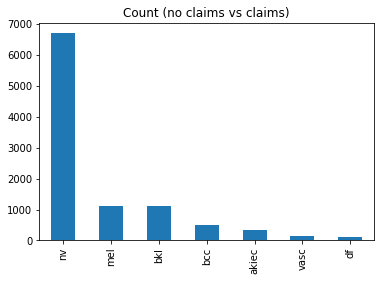

In [11]:
count.plot(kind='bar', title='Count (no claims vs claims)');

In [12]:
# group age
bins =[0,10,20,30,40,50,60,70,80,90]
labels = ['children','teenage','young','adult','midage','old1','old2','old3','older']

df['ageGroup'] = pd.cut(df['age'], bins=bins, labels=labels, right=False)

df = df.drop("age", axis=1)

In [13]:
# {0: 'akiec', 1: 'bcc', 2: 'bkl', 3: 'df', 4: 'mel', 5: 'nv', 6: 'vasc'}
dx_dict = dict(enumerate(df['dx'].astype('category').cat.categories))

# {0: 'confocal', 1: 'consensus', 2: 'follow_up', 3: 'histo'}
dx_type_dict = dict(enumerate(df['dx_type'].astype('category').cat.categories))

# {0: 'female', 1: 'male', 2: 'unknown'}
sex_dict = dict(enumerate(df['sex'].astype('category').cat.categories))

# {0: 'abdomen', 1: 'acral', 2: 'back', 3: 'chest', 4: 'ear',
# 5: 'face', 6: 'foot', 7: 'genital', 8: 'hand', 9: 'lower extremity',
# 10: 'neck', 11: 'scalp', 12: 'trunk', 13: 'unknown', 14: 'upper extremity'}
localization_dict = dict(enumerate(df['localization'].astype('category').cat.categories))

# {0: 'children', 1: 'teenage', 2: 'young', 3: 'adult', 4: 'midage',
# 5: 'old', 6: 'old2', 7: 'old3', 8: 'older'}
ageGroup_dict = dict(enumerate(df['ageGroup'].astype('category').cat.categories))

In [14]:
# encode 'dx','dx_type','sex', 'localization'
for col in ['dx','dx_type','sex','localization','ageGroup']:
    df[col] = df[col].astype('category') # Convert to category type
    df[col] = df[col].cat.codes # Convert to numerical code

In [15]:
df.head(10)

,image_id,dx,dx_type,sex,localization,ageGroup
lesion_id,,,,,,
HAM_0000550,ISIC_0024306,5,2,1,12,4
HAM_0003577,ISIC_0024307,5,2,1,9,5
HAM_0001477,ISIC_0024308,5,2,0,12,5
HAM_0000484,ISIC_0024309,5,2,1,12,4
HAM_0003350,ISIC_0024310,4,3,1,3,6
HAM_0000981,ISIC_0024311,5,2,0,2,7
HAM_0001359,ISIC_0024312,2,3,1,9,7
HAM_0002869,ISIC_0024313,4,3,0,2,5
HAM_0002198,ISIC_0024314,5,3,1,9,7


In [16]:
dict_image = {pil_img[i]: df.dx[i] for i in range(len(pil_img))}

In [17]:
proper_dict = {k:v for k,v in dict_image.items() if v == 2 or v ==4}

In [18]:
proper_dict

{tensor([[[-0.9020, -0.8849, -0.9020,  ..., -0.7822, -0.8335, -0.7993],
          [-0.8849, -0.8849, -0.8849,  ..., -0.7822, -0.8164, -0.8164],
          [-0.8849, -0.9192, -0.9192,  ..., -0.7993, -0.8164, -0.7993],
          ...,
          [-0.7822, -0.7479, -0.7650,  ..., -0.8678, -0.8678, -0.9020],
          [-0.8164, -0.7993, -0.7993,  ..., -0.8849, -0.8849, -0.8849],
          [-0.7993, -0.8164, -0.8335,  ..., -0.8849, -0.8849, -0.8849]],
 
         [[-1.4405, -1.4755, -1.4755,  ..., -1.5280, -1.5105, -1.5105],
          [-1.4755, -1.4580, -1.4755,  ..., -1.5105, -1.5105, -1.5105],
          [-1.4580, -1.4755, -1.4755,  ..., -1.5105, -1.4930, -1.4930],
          ...,
          [-1.4405, -1.4230, -1.4405,  ..., -1.4930, -1.4755, -1.4755],
          [-1.4405, -1.4405, -1.4405,  ..., -1.4755, -1.4755, -1.4755],
          [-1.4405, -1.4405, -1.4405,  ..., -1.4755, -1.4755, -1.4755]],
 
         [[-1.1596, -1.1247, -1.1421,  ..., -1.2293, -1.2467, -1.2467],
          [-1.1770, -1.1596,

In [19]:
newdf = df.loc[df['dx'].isin([2, 4])]

In [20]:
newdf.head()

,image_id,dx,dx_type,sex,localization,ageGroup
lesion_id,,,,,,
HAM_0003350,ISIC_0024310,4,3,1,3,6
HAM_0001359,ISIC_0024312,2,3,1,9,7
HAM_0002869,ISIC_0024313,4,3,0,2,5
HAM_0007538,ISIC_0024315,4,3,1,12,5
HAM_0002493,ISIC_0024323,4,3,1,9,5


In [21]:
image_fulldata_list = list(proper_dict.items())

In [22]:
train_image_list_with_target, test_image_list_with_target = train_test_split(image_fulldata_list, test_size=0.2,shuffle=True ,random_state=45)

In [23]:
train_image_list_with_target

[(tensor([[[ 1.9235,  1.9407,  1.9407,  ...,  1.4440,  1.1529,  0.7933],
           [ 1.9235,  1.9407,  1.9235,  ...,  1.4269,  1.0844,  0.7591],
           [ 1.9064,  1.9407,  1.9920,  ...,  1.4269,  0.8447,  0.6392],
           ...,
           [ 1.8379,  1.9235,  1.9235,  ...,  1.5468,  1.4783,  1.4783],
           [ 1.7694,  1.8722,  1.8379,  ...,  1.5639,  1.4954,  1.4954],
           [ 1.8037,  1.7694,  1.7352,  ...,  1.5810,  1.5125,  1.4783]],
  
          [[ 0.7829,  0.7829,  0.8354,  ...,  0.0476, -0.0574, -0.3025],
           [ 0.7654,  0.7829,  0.8529,  ...,  0.0651, -0.1450, -0.3550],
           [ 0.7829,  0.7829,  0.8529,  ...,  0.0476, -0.3550, -0.4251],
           ...,
           [ 0.9230,  1.0105,  1.0105,  ...,  0.3978,  0.3277,  0.3102],
           [ 0.9055,  0.9580,  0.8880,  ...,  0.4503,  0.3452,  0.3277],
           [ 0.8880,  0.8529,  0.7829,  ...,  0.5028,  0.4153,  0.3452]],
  
          [[ 1.2457,  1.2980,  1.2805,  ...,  0.8971,  0.6705,  0.3219],
           

In [24]:
batch_size = 16
train_loader_resnet = DataLoader(train_image_list_with_target,batch_size=batch_size, shuffle=True)
test_loader_resnet = DataLoader(test_image_list_with_target,batch_size=batch_size, shuffle=False)

In [25]:
# Set random seeds for reproducibility
torch.manual_seed(0)
if torch.cuda.is_available():
    torch.cuda.manual_seed(0)

In [26]:
for X, y in train_loader_resnet:
  print(X.shape, y.shape)

torch.Size([16, 3, 224, 224]) torch.Size([16])
torch.Size([16, 3, 224, 224]) torch.Size([16])
torch.Size([16, 3, 224, 224]) torch.Size([16])
torch.Size([16, 3, 224, 224]) torch.Size([16])
torch.Size([16, 3, 224, 224]) torch.Size([16])
torch.Size([16, 3, 224, 224]) torch.Size([16])
torch.Size([16, 3, 224, 224]) torch.Size([16])
torch.Size([16, 3, 224, 224]) torch.Size([16])
torch.Size([16, 3, 224, 224]) torch.Size([16])
torch.Size([16, 3, 224, 224]) torch.Size([16])
torch.Size([16, 3, 224, 224]) torch.Size([16])
torch.Size([16, 3, 224, 224]) torch.Size([16])
torch.Size([16, 3, 224, 224]) torch.Size([16])
torch.Size([16, 3, 224, 224]) torch.Size([16])
torch.Size([16, 3, 224, 224]) torch.Size([16])
torch.Size([16, 3, 224, 224]) torch.Size([16])
torch.Size([16, 3, 224, 224]) torch.Size([16])
torch.Size([16, 3, 224, 224]) torch.Size([16])
torch.Size([16, 3, 224, 224]) torch.Size([16])
torch.Size([16, 3, 224, 224]) torch.Size([16])
torch.Size([16, 3, 224, 224]) torch.Size([16])
torch.Size([1

In [ ]:
#with open('./read_imgs.pkl','wb') as fp:
  #pkl.dump(cv_img,fp)

In [ ]:
#with open('./read_imgs.pkl', 'rb') as fp:
  #imgs = pkl.load(fp)

In [27]:
def train_model(model,criterion,optimizer,train_loader,n_epochs,device):
    
    loss_over_time = [] # to track the loss as the network trains
    
    model = model.to(device) # Send model to GPU if available
    model.train() # Set the model to training mode
    
    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0
        
        for i, data in enumerate(train_loader):
            
            # Get the input images and labels, and send to GPU if available
            inputs, labels = data[0].to(device), data[1].type(torch.LongTensor).to(device)  # add .type(torch.LongTensor) to change label to long tensor

            # Zero the weight gradients
            optimizer.zero_grad()

            # Forward pass to get outputs
            outputs = model(inputs)

            # Calculate the loss
            loss = criterion(outputs, labels)

            # Backpropagation to get the gradients with respect to each weight
            loss.backward()

            # Update the weights
            optimizer.step()

            # Convert loss into a scalar and add it to running_loss
            running_loss += loss.item()
            
            if i % 100 == 99:    # print every 1000 batches
                avg_loss = running_loss/100
                # record and print the avg loss over the 1000 batches
                loss_over_time.append(avg_loss)
                print('Epoch: {}, Batch: {}, Avg. Loss: {:.4f}'.format(epoch + 1, i+1, avg_loss))
                running_loss = 0.0

    return loss_over_time

In [28]:
def test_model(model,test_loader,device):
    model = model.to(device)
    # Turn autograd off
    with torch.no_grad():

        # Set the model to evaluation mode
        model.eval()

        # Set up lists to store true and predicted values
        y_true = []
        test_preds = []
        probability = []
        # Calculate the predictions on the test set and add to list
        for data in test_loader:
            inputs, labels = data[0].to(device), data[1].type(torch.LongTensor).to(device)
            # Feed inputs through model to get raw scores
            logits = model.forward(inputs)                     #model_resnet                                         # change net to cost_path
            # Convert raw scores to probabilities (not necessary since we just care about discrete probs in this case)
            probs = F.softmax(logits,dim=1)
            print('#########################################')
            print(probs)
            print('#########################################')
            # Get discrete predictions using argmax
            preds = np.argmax(probs.cpu().numpy(),axis=1)
            # Add predictions and actuals to lists
            test_preds.extend(preds)
            y_true.extend(labels)
            
            probability.extend(probs)



        # Calculate the accuracy
        # test_preds = np.array(test_preds)
        # y_true = np.array(y_true)
        test_acc = sum([test_preds[i] == y_true[i] for i in range(len(y_true))])/len(y_true)


        
        # Recall for each class
        recall_vals = []
        for i in [2,4]:
            # print(y_true[0])
            class_idx = [j for j in range(len(y_true)) if y_true[j].item() == i] # np.argwhere(y_true==i)
            total = len(class_idx)
            correct = sum([test_preds[idx]==i for idx in class_idx])
            recall = correct / total
            recall_vals.append(recall)
    
    return test_acc,recall_vals,probability

In [29]:
images, labels = iter(train_loader_resnet).next()

In [30]:
# Load a resnet18 pre-trained model
model_resnet = torchvision.models.resnet18(pretrained=True)
# Shut off autograd for all layers to freeze model so the layer weights are not trained
for param in model_resnet.parameters():
    param.requires_grad = False
  
summary(model_resnet,(images.shape[1:]),batch_size=batch_size,device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [16, 64, 112, 112]           9,408
       BatchNorm2d-2         [16, 64, 112, 112]             128
              ReLU-3         [16, 64, 112, 112]               0
         MaxPool2d-4           [16, 64, 56, 56]               0
            Conv2d-5           [16, 64, 56, 56]          36,864
       BatchNorm2d-6           [16, 64, 56, 56]             128
              ReLU-7           [16, 64, 56, 56]               0
            Conv2d-8           [16, 64, 56, 56]          36,864
       BatchNorm2d-9           [16, 64, 56, 56]             128
             ReLU-10           [16, 64, 56, 56]               0
       BasicBlock-11           [16, 64, 56, 56]               0
           Conv2d-12           [16, 64, 56, 56]          36,864
      BatchNorm2d-13           [16, 64, 56, 56]             128
             ReLU-14           [16, 64,

In [34]:
# Replace the resnet input layer to take in grayscale images (1 input channel), since it was trained on color (3 input channels)
in_channels = 3
model_resnet.conv1 = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Replace the resnet final layer with a new fully connected Linear layer we will train on our task
# Number of out units is number of classes (7)
num_ftrs = model_resnet.fc.in_features
model_resnet.fc = nn.Linear(num_ftrs, 1)

# Train the model
n_epochs = 20
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_resnet.parameters(), lr=0.001)
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
print(device)
cost_path = train_model(model_resnet, criterion, optimizer, train_loader_resnet, n_epochs,device)

# Visualize the loss as the network trained
plt.plot(cost_path)
plt.xlabel('Batch (100s)')
plt.ylabel('loss')
plt.show()

cpu


RuntimeError: ignored

In [ ]:
classes = ['2', '4']

In [ ]:
# Test the pre-trained model
acc,recall_vals = test_model(model_resnet,test_loader_resnet,device)
print('Test set accuracy is {:.3f}'.format(acc))
for i in range(2):
    print('For class {}, recall is {}'.format(classes[i],recall_vals[i]))

In [ ]:
!ls

In [ ]:
%cd /content/drive/"My Drive"/AIPI540

In [ ]:
#torch.save(model_resnet.state_dict(),'deep_model_state.pt')

In [ ]:
filename = 'deep_fullmodel.pt'

# Save the entire model
torch.save(model_resnet, filename)

In [ ]:
url1 = 'https://github.com/Buuuuli/AIPI540_individual/blob/main/metadata/raw_metadata.csv?raw=true'

In [ ]:
url = 'https://github.com/Buuuuli/AIPI540_individual/blob/main/metadata/tidy_data.csv?raw=true'
df = pd.read_csv(url1,index_col=0)
print(df.head(5))

In [ ]:
df.dx.value_counts()

In [ ]:
#df['dx'] = df['dx'].map({"nv":0,"mel":1,"bkl":2,"bcc":3,"akiec":4,"vasc":5,"df":6})

In [ ]:
# group age
bins =[0,10,20,30,40,50,60,70,80,90]
labels = ['children','teenage','young','adult','midage','old1','old2','old3','older']

df['ageGroup'] = pd.cut(df['age'], bins=bins, labels=labels, right=False)

df = df.drop("age", axis=1)

In [ ]:
# {0: 'akiec', 1: 'bcc', 2: 'bkl', 3: 'df', 4: 'mel', 5: 'nv', 6: 'vasc'}
dx_dict = dict(enumerate(df['dx'].astype('category').cat.categories))

# {0: 'confocal', 1: 'consensus', 2: 'follow_up', 3: 'histo'}
dx_type_dict = dict(enumerate(df['dx_type'].astype('category').cat.categories))

# {0: 'female', 1: 'male', 2: 'unknown'}
sex_dict = dict(enumerate(df['sex'].astype('category').cat.categories))

# {0: 'abdomen', 1: 'acral', 2: 'back', 3: 'chest', 4: 'ear',
# 5: 'face', 6: 'foot', 7: 'genital', 8: 'hand', 9: 'lower extremity',
# 10: 'neck', 11: 'scalp', 12: 'trunk', 13: 'unknown', 14: 'upper extremity'}
localization_dict = dict(enumerate(df['localization'].astype('category').cat.categories))

# {0: 'children', 1: 'teenage', 2: 'young', 3: 'adult', 4: 'midage',
# 5: 'old', 6: 'old2', 7: 'old3', 8: 'older'}
ageGroup_dict = dict(enumerate(df['ageGroup'].astype('category').cat.categories))

In [ ]:
# encode 'dx','dx_type','sex', 'localization'
for col in ['dx','dx_type','sex','localization','ageGroup']:
    df[col] = df[col].astype('category') # Convert to category type
    df[col] = df[col].cat.codes # Convert to numerical code

In [ ]:
df.dx.value_counts()

In [ ]:
#df['dx_type'] = df['dx_type'].map({"histo":0,"follow_up":1,"consensus":2,"confocal":3})

In [ ]:
#df.sex.value_counts()

In [ ]:
#df['sex'] = df['sex'].map({"male":0,"female":1,"unknow":2})

In [ ]:
#df.localization.value_counts()

In [ ]:
#df['localization'] = df['localization'].map({"back":0,"lower extremity":1,"trunk":2,"upper extremity":3,"abdomen":4,"face":5,"chest":6,
                                             "foot":7,"unkown":8,"neck":9,"scalp":10,"hand":11,"ear":12,"genital":13,"acral":14})

In [ ]:
#df.ageGroup.value_counts()

In [ ]:
#df['ageGroup'] = df['ageGroup'].map({"teenage":0,"children":1,"young":2,"older":3,"adult":4,"old3":5,"old2":6,
                                             "old1":7,"midage":8})

In [ ]:
#df.head()

In [ ]:
X_meta = newdf[['dx_type','sex','localization','ageGroup']]

In [ ]:
y_meta = newdf[['dx']]

In [ ]:
X_train_meta, X_test_meta, y_train_meta, y_test_meta = train_test_split(X_meta, y_meta, test_size=0.2,shuffle=True ,random_state=45)

In [ ]:
from sklearn.model_selection import GridSearchCV

params = {'min_samples_leaf':[1,3,10],'n_estimators':[100,1000],
          'max_features':[0.1,0.5,1.],'max_samples':[0.5,None],'max_depth':[2]}

model = RandomForestClassifier()
grid_search = GridSearchCV(model,params,cv=3,verbose=10)
grid_search.fit(X_train_meta,y_train_meta)

In [ ]:
grid_search.best_params_

In [ ]:
# Run the model using the parameters found from the grid search
rf_model_meta = RandomForestClassifier(criterion='gini',max_depth=2, min_samples_leaf=10,n_estimators=100,
                                 max_features=0.1,max_samples=0.5,random_state=0)
rf_model_meta.fit(X_train_meta, y_train_meta)

In [ ]:
test_preds = rf_model_meta.predict(X_test_meta).reshape(len(X_test_meta),1)
test_acc = np.sum(test_preds==y_test_meta)/len(y_test_meta)


In [ ]:
test_acc

In [ ]:
print(classification_report(y_test_meta, test_preds))

In [ ]:
meta_test_0_5 = X_test_meta.iloc[0:5]

In [ ]:
meta_test_0_5

In [ ]:
test_0_5 = train_image_list_with_target[0:5]

In [ ]:
test_0_5

In [ ]:
image_testloader_0_5 = DataLoader(test_0_5,batch_size=batch_size, shuffle=False)

In [ ]:
# Test the pre-trained model
acc, recall_vals,prob = test_model(model_resnet,image_testloader_0_5,device)
print(prob)

print('Test set accuracy is {:.3f}'.format(acc))
for i in range(2):
    print('For class {}, recall is {}'.format(classes[i],recall_vals[i]))

In [ ]:
meta_subtest_prob = rf_model_meta.predict_proba(meta_test_0_5)

In [ ]:
meta_subtest_prob

In [ ]:
sub_test_predict = rf_model_meta.predict(meta_test_0_5)

In [ ]:
sub_test_predict

In [ ]:
def calc_feature_importances(model,feat_names,num_to_show):
    # Determine the relative importance of each feature using the random forest model
    importances = model.feature_importances_
    # Get an array of the indices that would sort "importances" in reverse order to get largest to smallest
    indices = np.argsort(importances)[::-1]
    ranked_feats = []
    for i in range(len(indices)):
        feat_name = feat_names[indices[i]]
        ranked_feats.append(feat_name)
    RF_ranking = pd.DataFrame()
    RF_ranking['Feat Index'] = indices
    RF_ranking['Feature'] = ranked_feats
    RF_ranking['Importance'] = np.sort(importances)[::-1]
    display(RF_ranking.iloc[:num_to_show,:])

    # Plot the importance value for each feature
    RF_ranking[:num_to_show][::-1].plot(x='Feature',y='Importance',kind='barh',figsize=(12,7),legend=False,title='RF Feature Importance')
    plt.show()
    return

In [ ]:
top_feats = 30
calc_feature_importances(rf_model_meta,X_test_meta.columns,top_feats)

In [ ]:
filename = 'randomforest.sav'
pkl.dump(rf_model_meta, open(filename, 'wb'))

In [ ]:
!ls